In [51]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial


py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from here. Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [52]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('//Users//sudhanmaharjan//Desktop//MSDS_DATA608_FALL2019//Module2//nyc_pluto_18v2_1_csv//pluto_18v2_1.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

Part 1: Binning and Aggregation
Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [53]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

Something looks off... You're going to have to deal with this imperfect data to answer this first question.

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

Hello all, here are some pandas tips to help you guys through this homework:

Indexing and Selecting: .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

Group By: This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a reset_index().

Reset_index: I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a huge section on datetime indexing. In particular, check out resample, which provides time series specific aggregation.

Merging, joining, and concatenation: There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [54]:
#Import the required library
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
# Brooklyn #
BK = pd.read_csv("/Users//sudhanmaharjan//Desktop//MSDS_DATA608_FALL2019//Module2//PLUTO17v1.1//BK2017V11.csv")
BK.head()

Borough  Block   Lot   CD  CT2010  CB2010  SchoolDist  Council  ZipCode  \
0      BK      1     1  302    21.0     NaN        13.0     33.0  11201.0   
1      BK      1    50  302    21.0  2000.0        13.0     33.0  11201.0   
2      BK      1  7501  302    21.0  2000.0        13.0     33.0  11201.0   
3      BK      3     1  302    21.0  3002.0        13.0     33.0  11201.0   
4      BK      3     5  302    21.0     NaN        13.0     33.0  11201.0   

  FireComp  ...  ZMCode  Sanborn   TaxMap  EDesigNum        APPBBL  \
0     L118  ...     NaN  302 007  30101.0        NaN  3.000010e+09   
1     L118  ...     NaN  302 007  30101.0      E-231  0.000000e+00   
2     L118  ...     NaN  302 007  30101.0        NaN  3.000010e+09   
3     L118  ...     NaN  302 007  30101.0        NaN  0.000000e+00   
4     L118  ...     NaN  302 007  30101.0        NaN  0.000000e+00   

      APPDate PLUTOMapID FIRM07_FLAG PFIRM15_FLAG Version  
0  11/26/2013          1         1.0          1.0  17v1.1  
1         NaN          1         1.0          1.0  17v1.1  
2    3/4/2016          1         1.0          1.0  17v1.1  
3         NaN          1         1.0          1.0  17v1.1  
4         NaN          4         1.0          1.0  17v1.1  

[5 rows x 87 columns]

In [56]:
# Bronx #
BX = pd.read_csv("/Users//sudhanmaharjan//Desktop//MSDS_DATA608_FALL2019//Module2//PLUTO17v1.1//BX2017V11.csv")
BX.head()

Borough  Block  Lot   CD  CT2010  CB2010  SchoolDist  Council  ZipCode  \
0      BX   2260    1  201    19.0  1022.0         7.0      8.0  10454.0   
1      BX   2260    4  201    19.0  1022.0         7.0      8.0  10454.0   
2      BX   2260   10  201    19.0  1022.0         7.0      8.0  10454.0   
3      BX   2260   17  201    19.0  1022.0         7.0      8.0  10454.0   
4      BX   2260   18  201    19.0  1022.0         7.0      8.0  10454.0   

  FireComp  ...  ZMCode  Sanborn   TaxMap  EDesigNum  APPBBL APPDate  \
0     L029  ...     NaN  209S016  20901.0      E-143     0.0     NaN   
1     L029  ...     NaN  209S016  20901.0      E-143     0.0     NaN   
2     L029  ...     NaN  209S016  20901.0      E-143     0.0     NaN   
3     L029  ...     NaN  209S016  20901.0      E-143     0.0     NaN   
4     L029  ...     NaN  209S016  20901.0      E-143     0.0     NaN   

  PLUTOMapID FIRM07_FLAG PFIRM15_FLAG Version  
0          1         NaN          NaN  17v1.1  
1          1         NaN          NaN  17v1.1  
2          1         NaN          NaN  17v1.1  
3          1         NaN          NaN  17v1.1  
4          1         NaN          NaN  17v1.1  

[5 rows x 87 columns]

In [57]:
# Manhattan #
MN = pd.read_csv("/Users//sudhanmaharjan//Desktop//MSDS_DATA608_FALL2019//Module2//PLUTO17v1.1//MN2017V11.csv")
MN.head()

Borough  Block  Lot   CD  CT2010  CB2010  SchoolDist  Council  ZipCode  \
0      MN    372   16  103   22.02  1000.0         1.0      2.0  10009.0   
1      MN    372   17  103   22.02  1000.0         1.0      2.0  10009.0   
2      MN    372   18  103   22.02  1000.0         1.0      2.0  10009.0   
3      MN    372   19  103   22.02  1000.0         1.0      2.0  10009.0   
4      MN    372   22  103   22.02  1000.0         1.0      2.0  10009.0   

  FireComp  ...  ZMCode  Sanborn   TaxMap  EDesigNum  APPBBL APPDate  \
0     E028  ...     NaN  102 014  10202.0        NaN     0.0     NaN   
1     E028  ...     NaN  102 014  10202.0        NaN     0.0     NaN   
2     E028  ...     NaN  102 014  10202.0        NaN     0.0     NaN   
3     E028  ...     NaN  102 014  10202.0        NaN     0.0     NaN   
4     E028  ...     NaN  102 014  10202.0        NaN     0.0     NaN   

  PLUTOMapID FIRM07_Flag PFIRM15_Flag Version  
0          1         NaN          NaN  17v1.1  
1          1         NaN          NaN  17v1.1  
2          1         NaN          NaN  17v1.1  
3          1         NaN          NaN  17v1.1  
4          1         NaN          NaN  17v1.1  

[5 rows x 87 columns]

In [58]:
# Queens #
QN = pd.read_csv("/Users//sudhanmaharjan//Desktop//MSDS_DATA608_FALL2019//Module2//PLUTO17v1.1//QN2017V11.csv")
QN.head()

Borough  Block  Lot   CD  CT2010  CB2010  SchoolDist  Council  ZipCode  \
0      QN    330   53  401    85.0  1005.0        30.0     26.0  11106.0   
1      QN    330   54  401    85.0  1005.0        30.0     26.0  11106.0   
2      QN    330   55  401    85.0  1005.0        30.0     26.0  11106.0   
3      QN    330  110  401    85.0  1005.0        30.0     26.0  11106.0   
4      QN    331    1  401    85.0  1004.0        30.0     26.0  11106.0   

  FireComp  ...  ZMCode  Sanborn   TaxMap  EDesigNum        APPBBL   APPDate  \
0     E260  ...     NaN  401 085  40301.0        NaN  4.003300e+09  8/8/2007   
1     E260  ...     NaN  401 085  40301.0        NaN  4.003300e+09  8/8/2007   
2     E260  ...     NaN  401 085  40301.0        NaN  4.003300e+09  8/8/2007   
3     E260  ...     NaN  401 085  40301.0        NaN  4.003300e+09  1/6/2006   
4     E260  ...     NaN  401 085  40301.0        NaN  0.000000e+00       NaN   

  PLUTOMapID FIRM07_FLAG PFIRM15_FLAG Version  
0          1         NaN          NaN  17v1.1  
1          1         NaN          NaN  17v1.1  
2          1         NaN          NaN  17v1.1  
3          1         NaN          NaN  17v1.1  
4          1         NaN          NaN  17v1.1  

[5 rows x 87 columns]

In [59]:
# Staten Island
SI = pd.read_csv("/Users//sudhanmaharjan//Desktop//MSDS_DATA608_FALL2019//Module2//PLUTO17v1.1//SI2017V11.csv")
SI.head()

Borough  Block  Lot   CD  CT2010  CB2010  SchoolDist  Council  ZipCode  \
0      SI    135   23  501    67.0  2005.0        31.0     49.0  10301.0   
1      SI    135   25  501    67.0  2005.0        31.0     49.0  10301.0   
2      SI    135   28  501    67.0  2005.0        31.0     49.0  10301.0   
3      SI    135   29  501    67.0  2005.0        31.0     49.0  10301.0   
4      SI    135   33  501    67.0  2005.0        31.0     49.0  10301.0   

  FireComp  ...  ZMCode  Sanborn   TaxMap  EDesigNum  APPBBL APPDate  \
0     E156  ...     NaN  501 086  50103.0        NaN     0.0     NaN   
1     E156  ...     NaN  501 086  50103.0        NaN     0.0     NaN   
2     E156  ...     NaN  501 086  50103.0        NaN     0.0     NaN   
3     E156  ...     NaN  501 086  50103.0        NaN     0.0     NaN   
4     E156  ...     NaN  501 086  50103.0        NaN     0.0     NaN   

  PLUTOMapID FIRM07_FLAG PFIRM15_FLAG Version  
0          1         NaN          NaN  17v1.1  
1          1         NaN          NaN  17v1.1  
2          1         NaN          NaN  17v1.1  
3          1         NaN          NaN  17v1.1  
4          1         NaN          NaN  17v1.1  

[5 rows x 87 columns]

In [60]:
# create the combined dataframe of all boros

df_nyc_all_borough = pd.concat([BK,BX,MN,QN,SI],sort='False')

# Getting rid of some outliers
df_nyc_all_borough = df_nyc_all_borough[(df_nyc_all_borough['YearBuilt'] > 1850) & (df_nyc_all_borough['YearBuilt'] < 2020) & (df_nyc_all_borough['NumFloors'] != 0)]
df_nyc_all_borough.head()

APPBBL APPDate              Address  AreaSource  AssessLand  AssessTot  \
1      0.0     NaN        10 JAY STREET           2      834300   10156950   
17     0.0     NaN    1 PLYMOUTH STREET           2      129600     351000   
20     0.0     NaN   65 PLYMOUTH STREET           2      178200     236700   
22     0.0     NaN  135 PLYMOUTH STREET           2      514350    7785450   
23     0.0     NaN        20 JAY STREET           2      972000   40980600   

           BBL  BldgArea BldgClass  BldgDepth  ...  YearAlter1  YearAlter2  \
1   3000010050    163894        O6      195.0  ...        1994        2015   
17  3000070021      9585        G1      113.0  ...        1988           0   
20  3000160005      5000        Q0      165.0  ...           0           0   
22  3000180001    211386        D5       48.0  ...        2014           0   
23  3000190001    500000        O6      207.0  ...        1999           0   

    YearBuilt ZMCode  ZipCode  ZoneDist1  ZoneDist2  ZoneDist3  ZoneDist4  \
1        1920    NaN  11201.0   M1-4/R8A       M3-1        NaN        NaN   
17       1988    NaN  11201.0       M3-1        NaN        NaN        NaN   
20       1920    NaN  11201.0       PARK        NaN        NaN        NaN   
22       1900    NaN  11201.0   M1-4/R8A        NaN        NaN        NaN   
23       1911    NaN  11201.0   M1-4/R8A        NaN        NaN        NaN   

    ZoneMap  
1       12d  
17      12d  
20      12d  
22      12d  
23      12d  

[5 rows x 89 columns]

In [61]:
df_yearBuilt = df_nyc_all_borough.loc[:, ['BBL','YearBuilt']]
df_yearBuilt.head()


BBL  YearBuilt
1   3000010050       1920
17  3000070021       1988
20  3000160005       1920
22  3000180001       1900
23  3000190001       1911

In [62]:
df_yearBuilt_nonzeros = df_yearBuilt.replace(0, pd.np.nan).dropna(axis=0, how='any').fillna(0).astype(int)

df_yearBuilt_nonzeros.head()


BBL  YearBuilt
1   3000010050       1920
17  3000070021       1988
20  3000160005       1920
22  3000180001       1900
23  3000190001       1911

Text(0.5,1.015,'Houses built in different years')

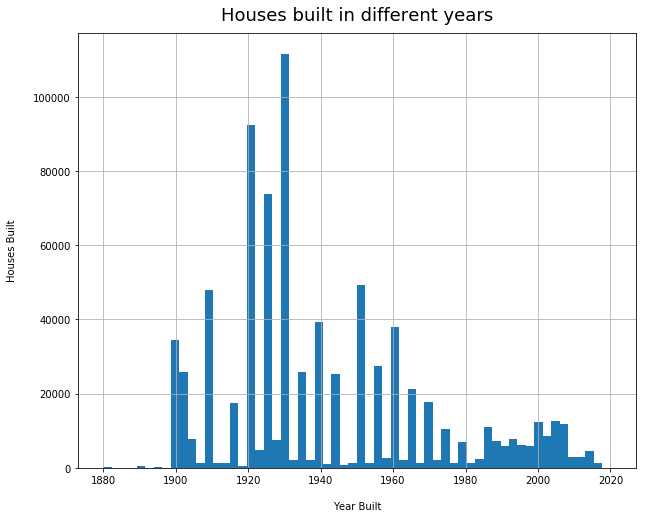

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

df_yearBuilt_nonzeros.hist(column='YearBuilt', range=[1880,2020], bins =60,figsize=[10,8])
plt.grid(axis='y', alpha=1)
plt.xlabel("Year Built", labelpad=16)
plt.ylabel("Houses Built", labelpad=16)
plt.title("Houses built in different years", y=1.015, fontsize=18)


The hightest number of houses built were in the year 1920s to 1930s. Overall the peak time were from 1900s to 1960s.

In [64]:
df_yearBuilt_nonzeros.count()

BBL          814035
YearBuilt    814035
dtype: int64

In [65]:
# generate summary statistics of YearBuilt 
print df_nyc_all_borough['YearBuilt'].describe()

count    814035.000000
mean       1940.924863
std          29.079540
min        1851.000000
25%        1920.000000
50%        1931.000000
75%        1960.000000
max        2017.000000
Name: YearBuilt, dtype: float64


In total 43699 records were of value 0 for YearBuilt that means the house built year was not known or there might have been error when data entry.

There is a record that YearBuilt is greater than 2025 which is not possible. We are in 2019 so there might have been error.

The houses built in different years seems little weird. There is no such thing that in certain years there was a boom in the housing and then later nothing happened. Housing business gradually grows and people start living on these. So let's figure out what can be done to make this dataset more meaningful.

In [81]:
#importing required libraries for the graph and later on 
import copy
import urllib
import json
import plotly # offline plotly
import plotly.offline as py
import datetime
import numpy as np 
import pandas as pd
import colorlover as cl
import chart_studio.plotly as py
import plotly.graph_objs as go
import datashader.transfer_functions as tf
from chart_studio.plotly import iplot
from plotly import tools
from functools import partial
from pyproj import Proj, transform

from bokeh.io import output_notebook, show # legend
from shapely.geometry import Point, Polygon, shape
from datashader.bokeh_ext import create_categorical_legend # legend
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # offline plotly

df_nyc_all_borough = df_nyc_all_borough[(df_nyc_all_borough['YearBuilt'] > 1880) & (df_nyc_all_borough['YearBuilt'] < 2020) & (df_nyc_all_borough['NumFloors'] != 0)]

nyc_yearbuilt_decades = df_nyc_all_borough[['YearBuilt', 'NumFloors', 'BBL']].copy() # Avoid case where changing df1 also changes df
nyc_yearbuilt_decades['YearBuilt'] = (np.ceil(nyc_yearbuilt_decades['YearBuilt'] / 10.0).astype(int) * 10) # round up to next decade

#now creating the figures
trace = go.Bar(
    x = nyc_yearbuilt_decades.groupby('YearBuilt').count()['BBL'].index,
    y = nyc_yearbuilt_decades.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Built Decade'),
    yaxis = dict(title = 'Number of Lots')
)

figure = go.Figure(data = [trace], layout = layout)
plotly.offline.plot(figure) # it creates a new temp-plot.html file for the graph


'temp-plot.html'

After represeting the data into graph for the above dataset it seems little off because it shows the builiding were built less after 1960 which is not possible.
So,further we have make sure that the graph represents what exactly the data is. 

We will be conducting the log on the dataset to see if it will make sense

In [82]:
height_distance = pd.DataFrame()
grouped = nyc_yearbuilt_decades.groupby(['YearBuilt', 'NumFloors'])
height_distance['Amount'] = grouped['NumFloors'].count()
subgrouped = height_distance.groupby(['YearBuilt'])['Amount']
height_distance['a'] = subgrouped.cumsum()/subgrouped.sum() 
alpha = 0.02 # significance used to define unusual

height_distance['Unusual'] = height_distance['a'] > (1 - alpha)
height_distance.groupby(['YearBuilt','Unusual']).filter(lambda x:(x['Unusual']==True).all())
builtyear_unsual = height_distance.groupby(['YearBuilt','Unusual']).sum()['Amount']

#creating the graph
trace1 = go.Bar(
    x = builtyear_unsual.unstack(level=-1)[False].index,
    y = builtyear_unsual.unstack(level=-1)[False],
    name='Bottom 99%'
)

trace2 = go.Bar(
    x = builtyear_unsual.unstack(level=-1)[True].index,
    y = builtyear_unsual.unstack(level=-1)[True],
    name='Top 1%'
)
layout = go.Layout(
    xaxis = dict(title = 'Built Decade'),
    yaxis = dict(title = 'Height Distribution (Log)',
                 showticklabels=False,
                 type = "log",
                 hoverformat = '.0f'),
    barmode = 'stack'
)
figure1 = go.Figure(data = [trace1, trace2], layout = layout)
plotly.offline.plot(figure1) # it creates a new temp-plot.html file for the graph

'temp-plot.html'

Now, let's group the floor of the buildings on the 10s value so that we can categorize it


In [68]:
nyc_binned_df = nyc_yearbuilt_decades.copy() # to avoid any changes on the previous df
building_floors = ((np.ceil(nyc_binned_df['NumFloors']) - 1) // 10 * 10 + 1).astype(int) 
nyc_binned_df['Binned'] = ['{0:03d} to {1:03d} Floors'.format(x, x+9) for x in building_floors] 
grouped = nyc_binned_df.groupby(['YearBuilt', 'Binned', 'NumFloors'])
nyc_building_floors = pd.DataFrame()
nyc_building_floors['Amount'] = grouped['NumFloors'].count()
floor_unstack = nyc_building_floors.groupby(['YearBuilt','Binned']).sum()['Amount'].unstack(level=-1, fill_value=0)
floor_unstack

Binned     001 to 010 Floors  011 to 020 Floors  021 to 030 Floors  \
YearBuilt                                                            
1890                     610                  3                  0   
1900                   34581                 80                  7   
1910                   82727                361                 14   
1920                  111491                498                 36   
1930                  165595                966                127   
1940                  101606                151                 17   
1950                   76068                102                 14   
1960                   69675                327                 56   
1970                   42131                533                175   
1980                   20678                159                 73   
1990                   25122                173                 95   
2000                   29681                 73                 35   
2010                   39754                379                 97   
2020                    8221                254                 84   

Binned     031 to 040 Floors  041 to 050 Floors  051 to 060 Floors  \
YearBuilt                                                            
1890                       0                  0                  0   
1900                       0                  0                  0   
1910                       1                  1                  0   
1920                       5                  2                  0   
1930                      33                 14                  6   
1940                      11                  6                  1   
1950                       2                  1                  1   
1960                      12                  4                  1   
1970                      63                 25                  6   
1980                      79                 24                  8   
1990                      79                 45                 10   
2000                      36                 12                  4   
2010                      59                 30                 24   
2020                      41                 32                 11   

Binned     061 to 070 Floors  071 to 080 Floors  081 to 090 Floors  \
YearBuilt                                                            
1890                       0                  0                  0   
1900                       0                  0                  0   
1910                       1                  0                  0   
1920                       1                  0                  0   
1930                       1                  0                  0   
1940                       3                  0                  1   
1950                       0                  0                  0   
1960                       0                  0                  0   
1970                       0                  0                  0   
1980                       0                  0                  1   
1990                       2                  1                  0   
2000                       1                  0                  0   
2010                       1                  3                  0   
2020                      13                 10                  5   

Binned     101 to 110 Floors  111 to 120 Floors  
YearBuilt                                        
1890                       0                  0  
1900                       0                  0  
1910                       0                  0  
1920                       0                  0  
1930                       0                  0  
1940                       1                  0  
1950                       0                  0  
1960                       0                  0  
1970                       0                  0  
1980                       0                  0  
1990                       0         

Since we can see there are 0 values in different columns lets fix this and since thre is very less value from floor 61 to 120 we can combine all these columns and make it 61 and above to determine that these buildings are all tall and caterogized as one category

In [69]:
floor_unstack['061 to 120 Floors'] = floor_unstack[floor_unstack.columns[6:11]].sum(axis=1)
floor_unstack = floor_unstack.drop(columns=floor_unstack.columns[6:11]).replace(0, np.nan)
floor_unstack

Binned     001 to 010 Floors  011 to 020 Floors  021 to 030 Floors  \
YearBuilt                                                            
1890                     610                  3                NaN   
1900                   34581                 80                7.0   
1910                   82727                361               14.0   
1920                  111491                498               36.0   
1930                  165595                966              127.0   
1940                  101606                151               17.0   
1950                   76068                102               14.0   
1960                   69675                327               56.0   
1970                   42131                533              175.0   
1980                   20678                159               73.0   
1990                   25122                173               95.0   
2000                   29681                 73               35.0   
2010                   39754                379               97.0   
2020                    8221                254               84.0   

Binned     031 to 040 Floors  041 to 050 Floors  051 to 060 Floors  \
YearBuilt                                                            
1890                     NaN                NaN                NaN   
1900                     NaN                NaN                NaN   
1910                     1.0                1.0                NaN   
1920                     5.0                2.0                NaN   
1930                    33.0               14.0                6.0   
1940                    11.0                6.0                1.0   
1950                     2.0                1.0                1.0   
1960                    12.0                4.0                1.0   
1970                    63.0               25.0                6.0   
1980                    79.0               24.0                8.0   
1990                    79.0               45.0               10.0   
2000                    36.0               12.0                4.0   
2010                    59.0               30.0               24.0   
2020                    41.0               32.0               11.0   

Binned     061 to 120 Floors  
YearBuilt                     
1890                     NaN  
1900                     NaN  
1910                     1.0  
1920                     1.0  
1930                     1.0  
1940                     5.0  
1950                     NaN  
1960                     NaN  
1970                     NaN  
1980                     1.0  
1990                     3.0  
2000                     1.0  
2010                     7.0  
2020                    28.0

Now lets graph the columns that we have just created 

In [83]:
data = []                 #dataframe info for traces
for i in range(0, len(floor_unstack.columns)):
    trace = go.Bar(
        x = floor_unstack[floor_unstack.columns[i]].index,
        y = floor_unstack[floor_unstack.columns[i]],
        name=floor_unstack.columns[i]
    )
    data.append(trace) 
layout = go.Layout(
    xaxis = dict(title = 'Built Decade'),
    yaxis = dict(title = 'Number of Lots (Log)',
                 showticklabels=False,
                 type = "log",
                 hoverformat = '.0f'),
    barmode = 'stack'
)

figure3 = go.Figure(data = data, layout = layout)
plotly.offline.plot(figure3) # it creates a new temp-plot.html file for the graph

'temp-plot.html'

Part 2: Datashader
    
Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [71]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(df_nyc_all_borough['YearBuilt'], np.linspace(df_nyc_all_borough['YearBuilt'].min(), df_nyc_all_borough['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(df_nyc_all_borough['NumFloors'], np.logspace(1, np.log(df_nyc_all_borough['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(df_nyc_all_borough['YearBuilt'].min(), df_nyc_all_borough['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(df_nyc_all_borough['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = df_nyc_all_borough.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Viridis', x = xlabels, y = ylabels)
]

plotly.offline.plot(data) # it creates a new temp-plot.html file for the graph


'temp-plot.html'

Here is what the same plot would look like in datashader:

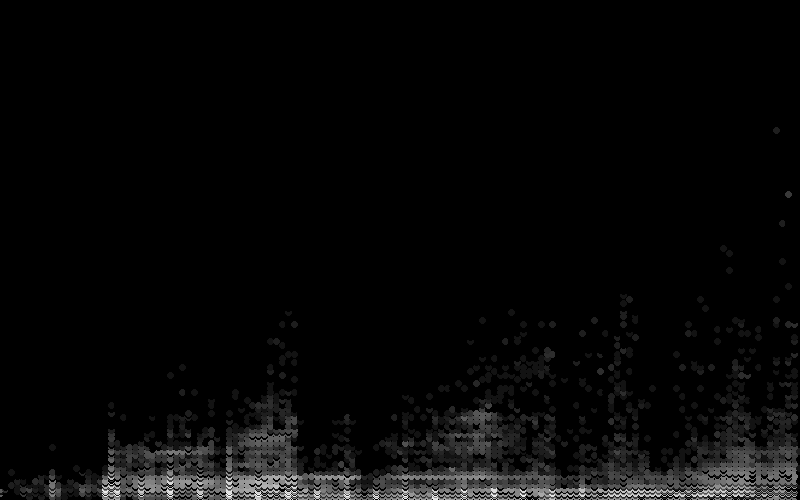

In [72]:
cvs = ds.Canvas(800, 500, x_range = (df_nyc_all_borough['YearBuilt'].min(), df_nyc_all_borough['YearBuilt'].max()), 
                          y_range = (df_nyc_all_borough['NumFloors'].min(), df_nyc_all_borough['NumFloors'].max()))
agg = cvs.points(df_nyc_all_borough, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=3), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

In [73]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc \
            +lat_1=40.66666666666666 \
            +lat_2=41.03333333333333 \
            +lat_0=40.16666666666666 \
            +lon_0=-74 \
            +x_0=300000 \
            +y_0=0 \
            +ellps=GRS80 \
            +datum=NAD83 \
            +to_meter=0.3048006096012192 \
            +no_defs")
df_nyc_all_borough['XCoord'] = 0.3048*df_nyc_all_borough['XCoord']
df_nyc_all_borough['YCoord'] = 0.3048*df_nyc_all_borough['YCoord']
df_nyc_all_borough['lon'], df_nyc_all_borough['lat'] = transform(nyli, wgs84, df_nyc_all_borough['XCoord'].values, df_nyc_all_borough['YCoord'].values)
df_nyc_all_borough = df_nyc_all_borough[(df_nyc_all_borough['lon'] < -60) & (df_nyc_all_borough['lon'] > -100) & (df_nyc_all_borough['lat'] < 60) & (df_nyc_all_borough['lat'] > 20)]
df_nyc_all_borough

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

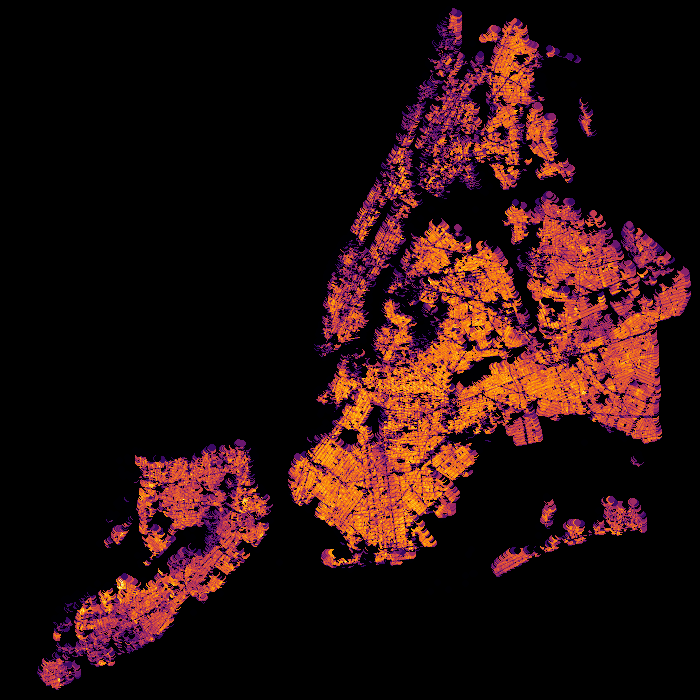

In [74]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(df_nyc_all_borough, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=3), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

In [75]:
#for the map of the NYC to display the density of buildings(tall buildings, private housese, town houses)
nyc_assessment = df_nyc_all_borough[['AssessTot', 'AssessLand','lon','lat']].copy() # to avoid any changes on previous df
nyc_assessment['AssessBldg'] = nyc_assessment['AssessTot'].sub(nyc_assessment['AssessLand'], axis=0)
labels = [['A', 'B', 'C'], ['1', '2', '3']] # three different classes in each variable
p = 100 / len(labels[0]) # percentile bins
q = np.percentile(nyc_assessment[['AssessLand', 'AssessBldg']], [p, 100 - p], axis=0) # breakpoints
nyc_assessment['Var1_Class'] = pd.cut(nyc_assessment['AssessLand'], [0, q[0][0], q[1][0], np.inf], right=False, labels=labels[0]) # bin
nyc_assessment['Var2_Class'] = pd.cut(nyc_assessment['AssessBldg'], [0, q[0][1], q[1][1], np.inf], right=False, labels=labels[1]) # bin
nyc_assessment['Bi_Class'] = nyc_assessment['Var1_Class'].astype(str) + nyc_assessment['Var2_Class'].astype(str)
nyc_assessment['Bi_Class'] = pd.Categorical(nyc_assessment['Bi_Class'])
nyc_assessment.head()

AssessTot  AssessLand        lon        lat  AssessBldg Var1_Class  \
1    10156950      834300 -73.987066  40.704619     9322650          C   
17     351000      129600 -73.989310  40.704109      221400          C   
20     236700      178200 -73.990608  40.704581       58500          C   
22    7785450      514350 -73.988008  40.704131     7271100          C   
23   40980600      972000 -73.987077  40.704101    40008600          C   

   Var2_Class Bi_Class  
1           3       C3  
17          3       C3  
20          3       C3  
22          3       C3  
23          3       C3

In [76]:
#sliced the data to our needed columns
nyc_assessment = nyc_assessment.loc[:, ['lon','lat','Bi_Class']]
nyc_assessment.head()

lon        lat Bi_Class
1  -73.987066  40.704619       C3
17 -73.989310  40.704109       C3
20 -73.990608  40.704581       C3
22 -73.988008  40.704131       C3
23 -73.987077  40.704101       C3

In [77]:
#lets bring the NYC into a map
NewYorkCity = (( -74.29,  -73.69), (40.49, 40.92))
canvas = ds.Canvas(800, 800, * NewYorkCity)
agg = canvas.points(nyc_assessment, 'lon', 'lat', ds.count_cat('Bi_Class'))
agg

<xarray.DataArray (lat: 800, lon: 800, Bi_Class: 9)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]], dtype=int32)
Coordinates:
  * lat       (lat) float64 40.49 40.49 40.49 40.49 ... 40.92 40.92 40.92 40.92
  * lon       (lon) float64 -74.29 -74.29 -74.29 -74.29 ... -73.69 -73.69 -73.69
  * Bi_Class  (Bi_Class) |S2 'A1' 'A2' 'A3' 'B1' 'B2' 'B3' 'C1' 'C2' 'C3'

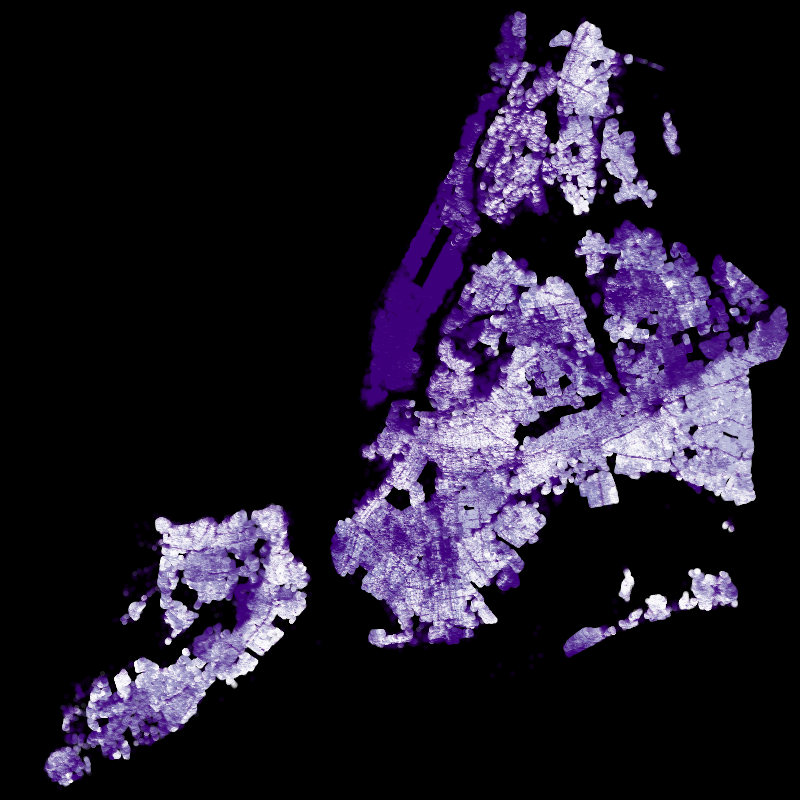

In [78]:
#to demonstrate different Bi_Class with different colors

cmap = {'A1': '#fcfbfd', 'A2': '#efedf5', 'A3': '#dadaeb', 
          'B1': '#bcbddc', 'B2': '#9e9ac8', 'B3': '#807dba', 
          'C1': '#6a51a3', 'C2': '#54278f', 'C3': '#3f007d'}


img = tf.shade(agg, color_key = cmap)
export(tf.spread(img, px=2),'Viridus')

Accoroding to the graph, it seems like Manhattan is highly crowed with tall buildings which makes sense. It is the city center of all the boroughs. Nearby part of Queens which is close to Manhattan has also tall buildings and Dumbo area in Brooklyn has all tall buildings according to the dense color in the map. As we can see some dense color in far Queens(Long Island border)area I am not sure about this because these are mostly residential area. There are lots of townhouses and private houses which are 2-3 storeys but in the map that area looks little dense.

References

https://plot.ly/python/offline/

https://plot.ly/ggplot2/geom_bar/

https://plot.ly/javascript/hover-events/

https://plot.ly/python/filled-area-plots/

https://pandas.pydata.org/pandas-docs/stable/categorical.html

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html

https://stackoverflow.com/questions/28101623/python-pyplot-histogram-adjusting-bin-width-not-number-of-bins

http://datashader.org/getting_started/2_Pipeline.html

https://www.color-hex.com/color/fcfbfd
